In [ ]:
pip install pyspark cloudscraper beautifulsoup4 nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install cloudscraper

In [ ]:
import cloudscraper
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, explode, split
from pyspark.sql.types import StringType, ArrayType
from collections import Counter
import pandas as pd

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Inicializa o Spark
spark = SparkSession.builder.appName("PerfumeScraperSpark").getOrCreate()

def clean_text(text):
    cleaned = re.sub(r'[^a-záàâãéèêíïóôõöúçñ0-9\s]', '', text.lower())
    return " ".join([w for w in cleaned.split() if w not in stop_words])

In [ ]:
# Registra como função
clean_text_udf = udf(clean_text, StringType())

def scrape_articles(base_url, num_articles=20, chars_limit=1000000):
    scraper = cloudscraper.create_scraper()
    articles_data = []

    try:
        print(f"Acessando a URL base: {base_url}")
        response = scraper.get(base_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        article_links = soup.select('h2 a')
        print(f"Encontrados {len(article_links)} links.")

        for i, link in enumerate(article_links[:num_articles]):
            title = link.get_text(strip=True)
            url = link.get('href')
            if not url.startswith('http'):
                url = base_url.rstrip('/') + '/' + url.lstrip('/')

            try:
                article_response = scraper.get(url)
                article_soup = BeautifulSoup(article_response.text, 'html.parser')
                article_main = article_soup.find('main', class_='entry', itemprop='articleBody')

                if article_main:
                    content = article_main.get_text(separator=' ', strip=True)
                else:
                    content = " ".join(p.get_text(strip=True) for p in article_soup.find_all('p'))

                articles_data.append((title, url, content[:chars_limit]))

            except Exception as e:
                print(f"Erro no artigo {url}: {e}")

    except Exception as e:
        print(f"Erro ao acessar URL base: {e}")

    return articles_data

In [ ]:
def count_phrases_spark(df, phrases):
    combined_text = " ".join(df.select("content").rdd.flatMap(lambda x: x).collect()).lower()
    counts = {phrase: combined_text.count(phrase.lower()) for phrase in phrases}
    sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)
    for phrase, count in sorted_counts:
        print(f"'{phrase}': {count}")

In [ ]:
if __name__ == "__main__":
    target_url = "https://garotasestupidas.com//"
    print("Iniciando scraping...")
    scraped_articles = scrape_articles(target_url, num_articles=20)

    if not scraped_articles:
        print("Nenhum artigo foi raspado.")
        exit()

    all_raw_contents_combined = " ".join([article[2] for article in scraped_articles])
    all_cleaned_contents = [clean_text(article[2]) for article in scraped_articles]

    print("\n--- Visão Geral dos Artigos Raspados ---")
    for article in scraped_articles:
        title = article[0]
        url = article[1]
        raw_content = article[2]

        print(f"Título: {title}")
        print(f"URL: {url}")
        print(f"Conteúdo (primeiros 200 caracteres): {raw_content[:200]}...")
        print("-" * 30)

#Conta quantas vezes cada palavra aparece
def count_phrases(text, phrases):
    counts = {}
    text_lower = text.lower()
    for phrase in phrases:
        # Conta as ocorrências de frase
        counts[phrase] = text_lower.count(phrase.lower())
    return counts

    ### Para as Palavras Mais Comuns
    df_cleaned = spark.createDataFrame([(text,) for text in all_cleaned_contents], ["cleaned_text"])
    df_words = df_cleaned.select(explode(split(col("cleaned_text"), "\s+")).alias("word"))

    broadcast_stopwords = spark.sparkContext.broadcast(stop_words)
    df_filtered = df_words.filter(
        (col("word") != "") & (~col("word").isin(list(broadcast_stopwords.value)))
    )

    word_counts = df_filtered.groupBy("word").count().orderBy("count", ascending=False)

    print("\n--- Palavras Mais Comuns (excluindo stopwords) ---")
    for row in word_counts.take(30):
        print(f"{row['word']}: {row['count']}")


    ### Para a Contagem de Palavras-Chave
    keywords_to_count = [ "acessório", "acompanhamento", "alongamento", "amadeirado", "amo", "atitude", "autoamor", "autoestima",
    "autoimagem", "autocuidado", "autoconfiança", "autenticidade", "beleza", "blogueira", "bodysplash",
    "bolsa", "bolsas", "celebridades", "Chanel", "charme", "closet", "comprinha", "confiança", "conforto",
    "cosméticos", "cupom", "date", "dancinha", "descoberta", "destino", "Dior", "doce", "e-commerce",
    "elegância", "elegante", "emoção", "energia", "enjoativo", "estampas", "estilo", "exclusividade",
    "experiência", "expressão", "falsificado", "favorito", "felicidade", "feminilidade", "feminino",
    "Floral", "força", "Fraco", "frescura", "Frutado", "glamour", "Glow", "Gucci", "hidratação",
    "identidade", "impressiona", "importado", "influencer", "influenciadora", "instagram", "instagramável",
    "inspiração", "irresistivel", "irresistiveis", "Lancôme", "lembrança", "lifestyle", "lip oil", "look",
    "looks", "Longa", "lugar", "luxo", "maquiagem", "Marcante", "memória", "minimalismo", "moda",
    "momento", "Mugler", "necessaire", "Original", "oriental", "outfit", "passaporte", "pele",
    "personalidade", "poder", "popular", "praia", "prazer", "presente", "presentinho", "produto",
    "protagonismo", "promoção", "refrescante", "relaxamento", "resenha", "Réplica", "rosto", "rotina",
    "Sedutor", "sensação", "sensual", "sensualidade", "serum", "Sexy", "signos", "similar", "skincare",
    "social", "sofisticado", "stories", "suavidade", "tendência", "testador", "TikTok", "toque",
    "transformação", "vibe", "verão", "vício", "viagem", "vitrine", "wishlist", "YSL"
    ]

    print("\n--- Contagem de Palavras-Chave ---")
    keywords_counts = count_phrases(all_raw_contents_combined, keywords_to_count)
    for phrase, count in sorted(keywords_counts.items(), key=lambda item: item[1], reverse=True):
        print(f"'{phrase}': {count}")


    ### Para a Contagem de Palavras/Termos Específicos
    phrases_to_count = [ "acessório", "acessórios de luxo feminino", "acompanhamento", "alongamento", "amadeirado", "amo", "amor próprio", "amor verdadeiro",
    "amostra grátis", "aroma acolhedor", "arrependimento de compra", "atitude", "autoamor", "autoestima", "autoimagem", "autocuidado",
    "autoconfiança", "autenticidade", "autenticidade feminina", "beleza", "beleza de dentro pra fora", "beleza natural", "beleza no verão",
    "blogueira", "blogueira famosa", "body splash", "bolsa", "bolsas", "café da manhã leve", "Carolina Herrera",
    "celebridades", "cheiro artificial", "cheiro de abraço", "cheiro de álcool", "cheiro de conforto", "cheiro de mulher rica",
    "cheiro marcante", "cheiro marcante e sofisticado", "cheiro que chama atenção", "cheiro que fixa", "checklist do dia", "Chanel",
    "charme", "cirurgia plastica", "closet", "como ser inesquecível", "como ser mais elegante", "como ser mais estilosa", "comprar online",
    "comprei influenciada", "comprei no escuro", "comprinha", "confiança", "conforto", "conteúdo de moda", "cosméticos", "cronograma capilar",
    "cupom de desconto", "date", "dancinha", "desejo de consumo", "detalhes que fazem a diferença", "descoberta", "destino romântico",
    "destinos internacionais", "diário da gratidão", "Dior", "dica de amiga", "dica de hotel", "dicas de autoestima", "dicas de beleza",
    "dicas para conquistar", "dicas para se sentir poderosa", "doce", "edição limitada", "e-commerce", "elegância", "elegante", "emoção",
    "energia", "energia boa", "energia feminina", "enjoativo", "esperava mais", "estampas", "estilo", "estilo de mulher poderosa",
    "estilo de vida", "exclusividade", "experiência", "experiência de compra", "experiência única", "expressão", "falsificado",
    "fashion week", "favorito", "favoritos da necessaire", "feed organizado", "felicidade", "feminilidade", "feminilidade moderna",
    "feminino", "feminino marcante", "fixação forte", "Floral", "força", "Fraco", "fragrância assinatura", "fragrância de luxo",
    "fragrância envolvente", "frescura", "frases de amor", "Frutado", "glamour", "Glow", "Gucci", "hidratação", "hotel dos sonhos",
    "idéia de surpresa", "ideias de presente para mulheres", "identidade", "impressiona", "importado", "influencer", "influenciadora",
    "influenciadora de beleza", "influenciadoras de moda", "instagram", "instagramável", "inspiração", "inspiração de estilo",
    "intensidade do perfume", "it girl", "item de desejo", "irresistivel", "irresistiveis", "jantar romântico", "Lancôme", "lembrança", "lifestyle", "lifestyle caro",
    "lifestyle viajante", "lip oil", "look", "look comfy", "look do dia", "look para jantar", "looks", "looks com personalidade",
    "looks elegantes e femininos", "looks para viajar", "Longa duração", "lugar poderoso", "luxo", "luxo acessível", "luxo discreto",
    "maquiagem", "marca de luxo", "Marcante", "me apaixonei pelo cheiro", "me decepcionou", "me faz lembrar alguém",
    "me faz sentir confiante", "me senti poderosa", "melhor perfume para cada tipo de pele", "melhores perfumes femininos",
    "melhores perfumes segundo influenciadoras", "memória", "mensagem fofa", "minha assinatura", "minimalismo", "moda",
    "moda consciente", "moda feminina", "moda feminina 2025", "momento", "momento a dois", "momento único", "momento...", "Mugler",
    "must-have de beleza", "não dura na pele", "não gostei", "não largo mais", "não vale o preço", "necessaire", "nova coleção",
    "o que usar em um primeiro encontro", "Original", "oriental", "outfit", "passagem promocional", "passaporte", "pele perfeita",
    "perfume amadeirado", "perfume assinatura", "perfume bom e duradouro", "perfume comum", "perfume com boa fixação",
    "perfume com boa projeção", "perfume com identidade", "perfume da minha vida", "perfume das famosas", "perfume de mulher elegante",
    "perfume de mulher poderosa", "perfume de verão", "perfume doce", "perfume elegante", "perfume enjoativo", "perfume exclusivo",
    "perfume feminino mais elogiado", "perfume floral", "perfume fraco", "perfume fresco", "perfume frutado", "perfume gourmand",
    "perfume ideal para casamento", "perfume importado original", "perfume leve para o dia", "perfume muito caro", "perfume noturno",
    "perfume para casamento", "perfume para conquistar", "perfume para encontros", "perfume para levantar o astral", "perfume para namorar",
    "perfume para o dia a dia", "perfume para o inverno", "perfume para o verão", "perfume para presentear", "perfume para primeira impressão",
    "perfume para sair à noite", "perfume para trabalho", "perfume que impressiona", "perfume que marca presença", "perfume que rende elogios",
    "perfume que some rápido", "perfume sedutor", "perfume sem fixação", "perfume sofisticado", "perfume unissex", "personalidade", "poder",
    "popular", "praia", "praia paradisíaca", "prazer", "presente", "presente de press kit", "presente especial", "presente para namorada",
    "presentinho", "produtinhos que amo", "produto premium", "produto queridinho", "produto viral", "produtos que duram o dia inteiro",
    "protagonismo feminino", "promoção especial", "refrescante", "relacionamento saudável", "relaxamento", "resenha",
    "resenha de perfume importado", "resenha sincera", "review de beleza", "review honesto", "ritual", "ritual de beleza", "Réplica",
    "rosto saudável", "rotina", "rotina de autocuidado", "rotina de cuidados", "rotina de final de semana", "rotina produtiva", "roupa de luxo",
    "Sedutor", "sem fixação", "sensação", "sensação de frescor", "sensual", "sensualidade", "serum", "Sexy", "signos", "similar", "skincare",
    "social", "sofisticado", "spa day", "stories", "style tips", "suavidade", "tendência", "tendência do momento", "tendências de beleza",
    "tendências de beleza 2025", "tendências de moda", "tendências fashion Brasil", "testador", "TikTok", "tipos de pele", "toque",
    "toque pessoal", "top 10 perfumes femininos 2025", "top favoritos", "transformação", "trend alert", "unboxing perfume importado", "vibe",
    "vibe feminina", "vibes positivas", "vale a pena perfume X?", "vale o hype?", "verão", "verão fashion", "vício", "vício do momento",
    "vida luxuosa", "vida saudável", "viagem", "viagem com estilo", "viagem dos sonhos", "viajar sozinha", "vídeo viral", "virou meu favorito",
    "vitrine", "wishlist", "YSL"
    ]

    print("\n--- Contagem de Palavras/Termos Específicos ---")
    phrase_counts = count_phrases(all_raw_contents_combined, phrases_to_count)
    for phrase, count in sorted(phrase_counts.items(), key=lambda item: item[1], reverse=True):
        print(f"'{phrase}': {count}")

Iniciando scraping...
Acessando a URL base: https://garotasestupidas.com//
Encontrados 17 links.

--- Visão Geral dos Artigos Raspados ---
Título: Marina Ruy Barbosa abre o jogo sobre sua fase com o cabelo loiro
URL: https://garotasestupidas.com/marina-ruy-barbosa-abre-o-jogo-sobre-sua-fase-com-o-cabelo-loiro/
Conteúdo (primeiros 200 caracteres): Conhecida por seu icônico ruivo, Marina Ruy Barbosa surpreendeu ao adotar fios loiríssimos. Junto com o novo visual, veio também uma nova forma de se expressar através da moda. Em conversa exclusiva c...
------------------------------
Título: Alerta de tendência: o clog é o sapato da vez
URL: https://garotasestupidas.com/alerta-de-tendencia-o-clog-e-o-sapato-da-vez/
Conteúdo (primeiros 200 caracteres): As tendências de moda apontam que agora é o momento do clog brilhar. Esse sapato, tradicionalmente fechado na frente e aberto atrás, tem ganhado o coração das fashionistas. Confortáveis e versáteis, e...
------------------------------
Título: Pa

In [ ]:
    print("\n--- Palavras Mais Comuns (excluindo stopwords) ---")
    for row in word_counts.take(30):
        print(f"{row['word']}: {row['count']}")


--- Palavras Mais Comuns (excluindo stopwords) ---
instagram: 19
desse: 19
vai: 18
marca: 18
gostou: 17
conteúdo: 17
gostar: 17
compartilhe: 17
escreve: 17
moda: 16
post: 15
coleção: 13
garotas: 11
pele: 11
tudo: 11
perfumes: 10
foto: 10
estilo: 10
reprodução: 9
by: 9
garotasestupidas: 9
martinez: 9
baárbara: 9
skincare: 9
abaixo: 9
dia: 9
rotina: 8
redes: 8
jaquelini: 8
almeida: 8


In [ ]:
    print("\n--- Contagem de Palavras-Chave ---")
    keywords_counts = count_phrases(all_raw_contents_combined, keywords_to_count)
    for phrase, count in sorted(keywords_counts.items(), key=lambda item: item[1], reverse=True):
        print(f"'{phrase}': {count}")


--- Contagem de Palavras-Chave ---
'amo': 22
'instagram': 19
'moda': 16
'pele': 11
'estilo': 10
'skincare': 9
'momento': 8
'rotina': 8
'acessório': 7
'força': 6
'look': 6
'beleza': 5
'looks': 5
'produto': 5
'maquiagem': 4
'poder': 4
'atitude': 3
'autocuidado': 3
'estampas': 3
'Marcante': 3
'elegante': 2
'favorito': 2
'identidade': 2
'influenciadora': 2
'inspiração': 2
'lugar': 2
'personalidade': 2
'rosto': 2
'tendência': 2
'TikTok': 2
'toque': 2
'charme': 1
'cosméticos': 1
'elegância': 1
'emoção': 1
'Glow': 1
'impressiona': 1
'popular': 1
'presente': 1
'transformação': 1
'acompanhamento': 0
'alongamento': 0
'amadeirado': 0
'autoamor': 0
'autoestima': 0
'autoimagem': 0
'autoconfiança': 0
'autenticidade': 0
'blogueira': 0
'bodysplash': 0
'bolsa': 0
'bolsas': 0
'celebridades': 0
'Chanel': 0
'closet': 0
'comprinha': 0
'confiança': 0
'conforto': 0
'cupom': 0
'date': 0
'dancinha': 0
'descoberta': 0
'destino': 0
'Dior': 0
'doce': 0
'e-commerce': 0
'energia': 0
'enjoativo': 0
'exclusividade':

In [ ]:
    print("\n--- Contagem de Palavras/Termos Específicos ---")
    phrase_counts = count_phrases(all_raw_contents_combined, phrases_to_count)
    for phrase, count in sorted(phrase_counts.items(), key=lambda item: item[1], reverse=True):
        print(f"'{phrase}': {count}")


--- Contagem de Palavras/Termos Específicos ---
'amo': 22
'instagram': 19
'moda': 16
'estilo': 10
'skincare': 9
'body splash': 8
'momento': 8
'rotina': 8
'acessório': 7
'força': 6
'look': 6
'beleza': 5
'looks': 5
'maquiagem': 4
'poder': 4
'atitude': 3
'autocuidado': 3
'estampas': 3
'Marcante': 3
'elegante': 2
'favorito': 2
'identidade': 2
'influenciadora': 2
'inspiração': 2
'personalidade': 2
'tendência': 2
'TikTok': 2
'toque': 2
'charme': 1
'cosméticos': 1
'elegância': 1
'emoção': 1
'Glow': 1
'impressiona': 1
'influenciadoras de moda': 1
'intensidade do perfume': 1
'item de desejo': 1
'lugar poderoso': 1
'nova coleção': 1
'popular': 1
'presente': 1
'tendências de moda': 1
'transformação': 1
'acessórios de luxo feminino': 0
'acompanhamento': 0
'alongamento': 0
'amadeirado': 0
'amor próprio': 0
'amor verdadeiro': 0
'amostra grátis': 0
'aroma acolhedor': 0
'arrependimento de compra': 0
'autoamor': 0
'autoestima': 0
'autoimagem': 0
'autoconfiança': 0
'autenticidade': 0
'autenticidade fem

##Nuvens

In [ ]:
pip install wordcloud matplotlib

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_wordcloud(frequencies, title):
    brown_cmap = LinearSegmentedColormap.from_list("brown_shades", [
        "#3e1f0d",  # marrom escuro
        "#8b5a2b",  # marrom médio
        "#cd853f",  # peru (peru brown)
        "#deb887",  # bege bronzeado
        "#f5deb3"   # trigo
    ])

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=brown_cmap,
        prefer_horizontal=0.95,
        max_words=100,
        contour_color='saddlebrown',
        contour_width=0.5
    )

    wc.generate_from_frequencies(frequencies)

    plt.figure(figsize=(15, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, color='#5a3a1a')
    plt.tight_layout()
    plt.show()

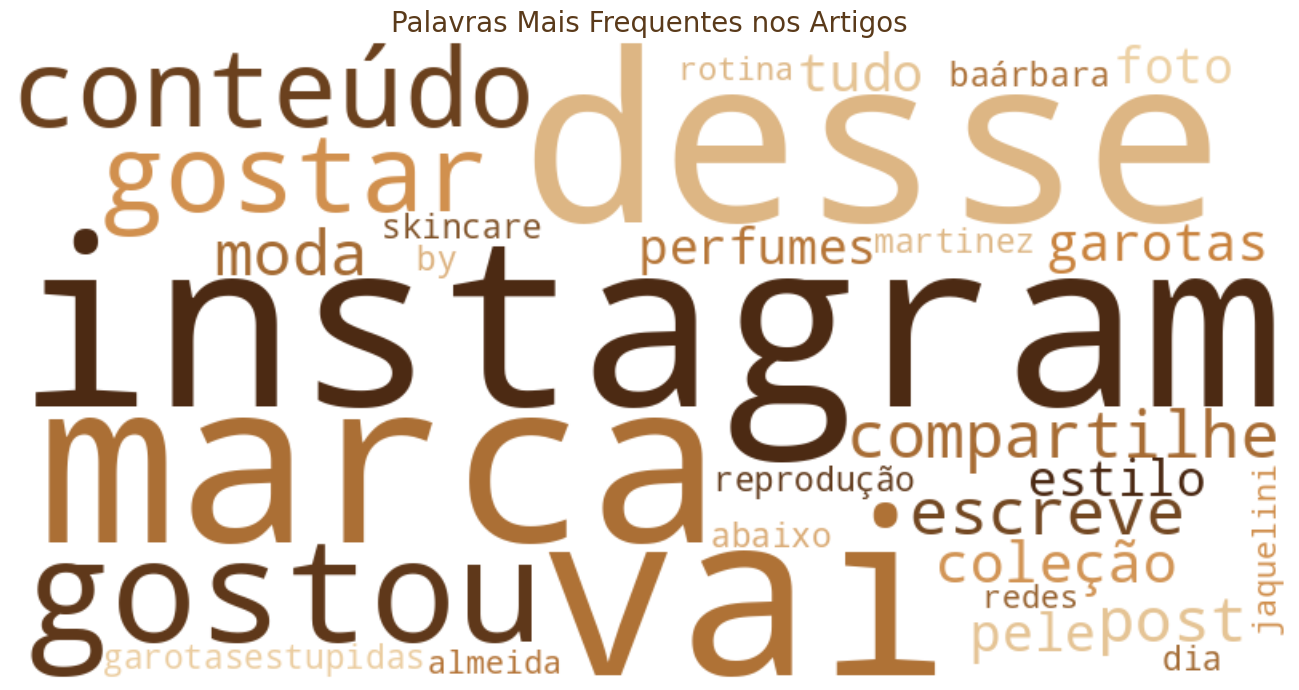

In [ ]:
# 1. Nuvem de palavras comuns (usando PySpark output)
word_freq_dict = {row['word']: row['count'] for row in word_counts.take(30)}
plot_wordcloud(word_freq_dict, "Palavras Mais Frequentes nos Artigos")

In [ ]:
# Mostrar a tabela das palavras mais frequentes nos artigos
top_words_df = word_counts.orderBy("count", ascending=False).limit(30)
top_words_df.show(truncate=False)

+----------------+-----+
|word            |count|
+----------------+-----+
|instagram       |19   |
|desse           |19   |
|vai             |18   |
|marca           |18   |
|gostou          |17   |
|conteúdo        |17   |
|gostar          |17   |
|compartilhe     |17   |
|escreve         |17   |
|moda            |16   |
|post            |15   |
|coleção         |13   |
|garotas         |11   |
|pele            |11   |
|tudo            |11   |
|perfumes        |10   |
|estilo          |10   |
|foto            |10   |
|reprodução      |9    |
|garotasestupidas|9    |
+----------------+-----+
only showing top 20 rows



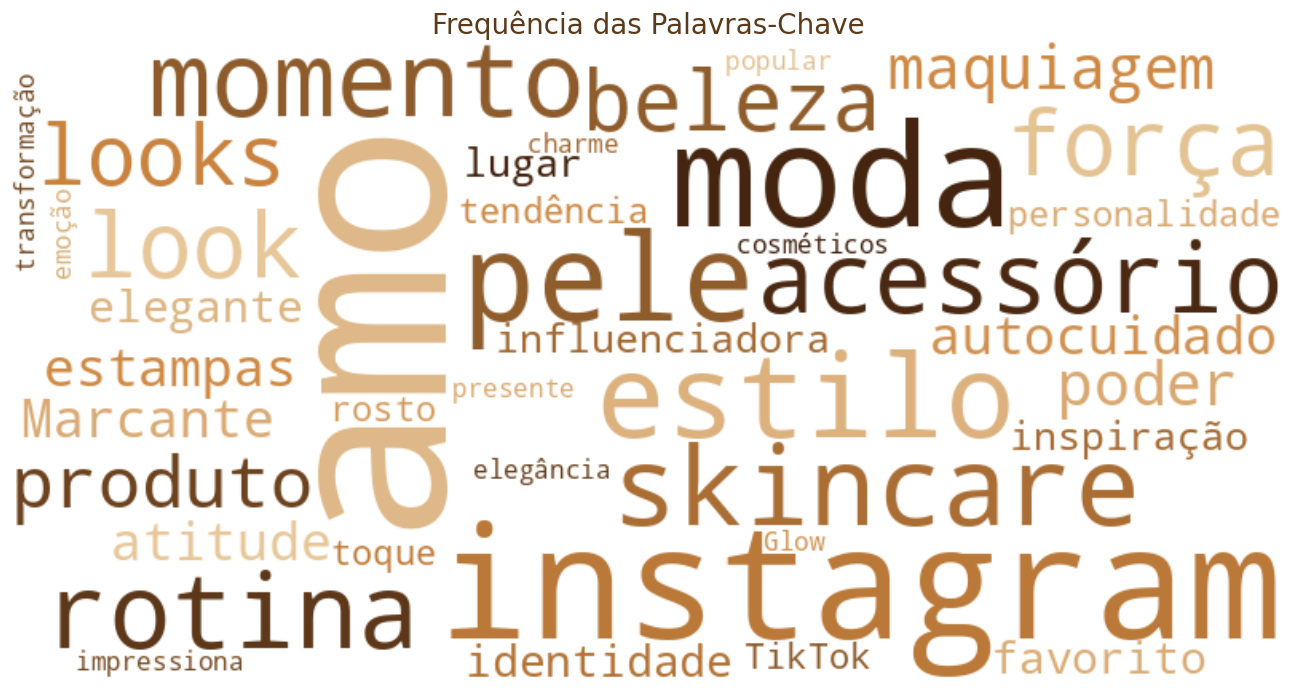

In [ ]:
# 2. Nuvem de Palavras-Chave
plot_wordcloud(keywords_counts, "Frequência das Palavras-Chave")

In [ ]:
#Tabela das Palavras-Chave
keywords_df = pd.DataFrame(
    sorted(keywords_counts.items(), key=lambda item: item[1], reverse=True),
    columns=["Palavra-chave", "Frequência"]
)

# Exibir a tabela
print(keywords_df)

    Palavra-chave  Frequência
0             amo          22
1       instagram          19
2            moda          16
3            pele          11
4          estilo          10
..            ...         ...
125         vício           0
126        viagem           0
127       vitrine           0
128      wishlist           0
129           YSL           0

[130 rows x 2 columns]


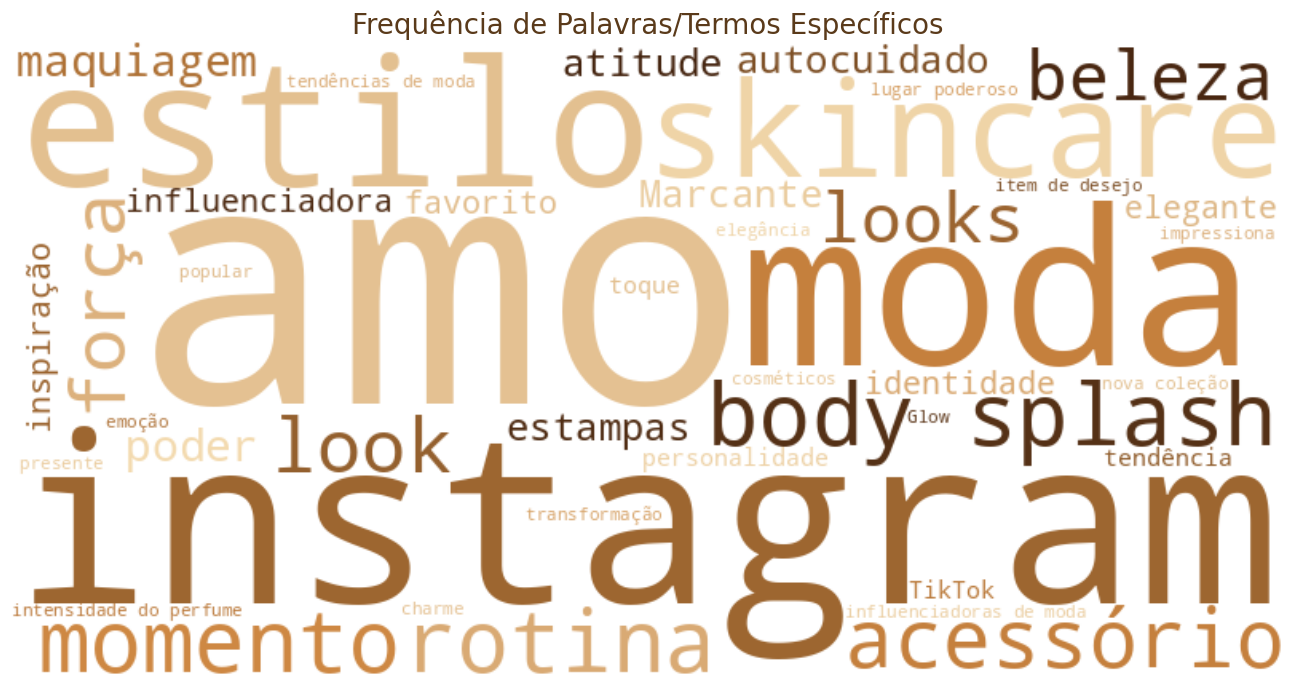

In [ ]:
# 3. Nuvem de Palavras/Termos selecionadas
plot_wordcloud(phrase_counts, "Frequência de Palavras/Termos Específicos")


In [ ]:
#Tabela de Palavras e Termos Específicos
phrases_df = pd.DataFrame(
    sorted(phrase_counts.items(), key=lambda item: item[1], reverse=True),
    columns=["Palavra/Termo Específico", "Frequência"]
)

# Exibe os dados como tabela
print(phrases_df)

#Exibe apenas os 30 mais comuns
# print(phrases_df.head(30))

    Palavra/Termo Específico  Frequência
0                        amo          22
1                  instagram          19
2                       moda          16
3                     estilo          10
4                   skincare           9
..                       ...         ...
325              vídeo viral           0
326       virou meu favorito           0
327                  vitrine           0
328                 wishlist           0
329                      YSL           0

[330 rows x 2 columns]


# Exportando para Excel

In [ ]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Caminho do arquivo Excel que será criado
arquivo_excel = "analisetexto_garotasestupidas.xlsx"

# Converte o DataFrame PySpark para Pandas antes de exportar
top_words_pandas_df = top_words_df.toPandas()

# Cria o arquivo com várias abas
with pd.ExcelWriter(arquivo_excel, engine='xlsxwriter') as writer:
    # Use o DataFrame Pandas convertido aqui
    top_words_pandas_df.to_excel(writer, sheet_name='Palavras Mais Comuns', index=False)
    keywords_df.to_excel(writer, sheet_name='Palavras-chave', index=False)
    phrases_df.to_excel(writer, sheet_name='Frases Específicas', index=False)

print(f"Tabelas exportadas com sucesso para '{arquivo_excel}'")

Tabelas exportadas com sucesso para 'analisetexto_garotasestupidas.xlsx'
